In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from iuvs import io, scaling

In [4]:
def calc_4_to_3(width):
    height = width * 3 / 4
    return (width, height)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['figure.figsize']= calc_4_to_3(12)
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'

In [6]:
def get_title(l1b):
    return os.path.basename(l1b.fname)[12:-16]

In [25]:
import os

def get_light_dark(l1b, index):
    if l1b.detector_raw.ndim == 3:
        raw = l1b.detector_raw[index]
    else:
        raw = l1b.detector_raw
    if l1b.detector_dark.ndim == 3:
        dark = l1b.detector_dark[index]
    else:
        dark = l1b.detector_dark
    return raw, dark

def show_image_overview(l1b, cmap=None):
    if cmap is None:
        cmap = 'binary'
    fig, axes = plt.subplots(nrows=2)
    raw, dark = get_dark_light(l1b)
    # raw
    vmin, vmax = np.percentile(raw, (2,98))
    im = axes[0].imshow(raw, vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar(im, ax=axes[0])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[0].set_title("raw light")
    # dark
    vmin, vmax = np.percentile(dark, (2,98))
    im2 = axes[1].imshow(dark, vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar(im2, ax=axes[1])
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(13)
    axes[1].set_title('dark')
    fig.suptitle("{} INT_TIME: {}\nP2-P98 stretch. SPA_BIN:{}, SPE_BIN:{}"
                 .format(get_title(l1b),
                         l1b.img_header['INT_TIME'],
                         l1b.img_header['SPA_SIZE'],
                         l1b.img_header['SPE_SIZE']),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_1.png', dpi=150)

In [8]:
import numpy as np

def img_profile_and_stats(img, l1b, title, spatialslice, spectralslice,
                          zmin=None, zmax=None, 
                          spatial=None, spectral=None,
                          ):
    fig, axes = plt.subplots(2, 2)
    if spatial is None:
        spatial = img.shape[0]//2
    if spectral is None:
        spectral = img.shape[1]//2

    
    no_nans = img[~np.isnan(img)]
    sliced = img[spatialslice, spectralslice]
    to_hist = sliced[~np.isnan(sliced)]
    if zmin is None:
        # set vis limits to 2, 98 percentile
        zmin, zmax = np.percentile(no_nans, (2, 98))

    prof1 = img[spatial]
    prof2 = img[:, spectral]
    axes = axes.ravel()
    im = axes[0].imshow(img, vmin=0, vmax=zmax)
    plt.colorbar(im, ax=axes[0])
    min_, max_ = np.percentile(prof2, (2,95))
    axes[1].plot(prof2)
    axes[1].set_ylim(min_, max_)
    axes[1].set_title('Spatial profile at middle spectral value')
    min_, max_ = np.percentile(prof1, (2,95))
    axes[2].plot(prof1)
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('Spectral profile at middle spatial value')
    to_hist = to_hist[to_hist < zmax]
    to_hist = to_hist[to_hist > zmin]
    axes[3].hist(to_hist.ravel(), bins=50, log=False, normed=True)
    axes[3].set_title("Median: {:.1f}, STD: {:.1f}".format(np.median(to_hist),
                                                           to_hist.std()),
                      fontsize=12)
    fig.suptitle("{}, Slice: [{}:{}, {}:{}]\n Img stretch: (0, P98), prof stretch: (P2, P95)"
                 .format(get_title(l1b)+' '+title,
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    if title == "LIGHT":
        no = 3
    else:
        no = 4
    fig.savefig('plots/'+get_title(l1b)+'_'+str(no)+'.png', dpi=150)

In [32]:
def poly_fitting(fullraw, fulldark, spatialslice, spectralslice):
    light = fullraw[spatialslice, spectralslice]
    dark = fulldark[spatialslice, spectralslice]
    scaler = scaling.PolyScaler(dark, light)
    scaler.do_fit()
    return scaler.apply_fit(fulldark)

def plot_profiles(l1b, spatialslice, spectralslice):
    fig, axes = plt.subplots(nrows=6, sharex=True)
    axes = axes.ravel()
    integration_index = -1
    light, dark = get_light_dark(l1b, integration_index)
    spatial = light.shape[0]//2
    
    #fitting
    fitted_dark = poly_fitting(light, dark, spatialslice, spectralslice)
    sub = light - fitted_dark
    min_, max_ = np.percentile(sub, (2, 92))
    dbs = l1b.detector_background_subtracted
    if dbs.ndim == 3:
        backsub = dbs[integration_index]
    else:
        backsub = dbs
        
    # raw light
    axes[0].plot(light[spatial])
    axes[0].set_title('Raw light')
    axes[0].set_ylim(min_, max_)
    
    # manual
    man_sub = light - dark
    axes[1].plot(man_sub[spatial])
    axes[1].set_title('manual subtraction: light - dark')
    axes[1].set_ylim(min_, max_)

    # l1b.det_back_subtr
    axes[2].plot(backsub[spatial])
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('l1b.detector_background_subtracted')
    
    # My sub
    axes[3].plot(sub[spatial])
    axes[3].set_ylim(min_, max_)
    axes[3].set_title('subtracted with fitted dark')
    
    # residual
    axes[4].plot(man_sub[spatial]/sub[spatial])
    axes[4].set_title('Ratio between manually subtracted and my fit-subtracted ')
    
    axes[5].plot(man_sub[spatial]/backsub[spatial])
    
    # title and saving
    fig.suptitle("{} Slice: [{}:{}, {}:{}]\nprofile stretch: (P2, P92), fixed to newest for comparison"
                 .format(get_title(l1b),
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_2.png', dpi=150)
    
    print((man_sub[spatial]/backsub[spatial]).mean())
    return sub

In [10]:
def plot_mean_profiles(l1b, spatialslice, spectralslice):
    fig, axes = plt.subplots(nrows=5, sharex=True)
    axes = axes.ravel()
    img, light, dark = get_img_dark_light(l1b)
    axes[0].semilogy(light.mean(axis=0))
    axes[0].set_title('light')
#     axes[0].set_ylim(2e3, 1e4)
    axes[1].semilogy(dark.mean(axis=0))
    axes[1].set_title('dark')
#     axes[1].set_ylim(1e3, 1e4)
    
    #fitting
    fitted_dark = poly_fitting(l1b, spatialslice, spectralslice)
    sub = light - fitted_dark
    min_, max_ = np.percentile(sub, (2, 92))
    dbs = l1b.detector_background_subtracted
    if dbs.ndim == 3:
        backsub = dbs[0]
    else:
        backsub = dbs
    axes[2].plot(backsub.mean(axis=0))
    axes[2].set_ylim(min_, max_)
    axes[2].set_title('detetor_background_subtracted')
    
    # my subtraction
    axes[3].plot(sub.mean(axis=0))
    axes[3].set_ylim(min_, max_)
    axes[3].set_title('subtracted with fitted dark')
    
    # old subtraction
    oldsub = light - dark
    axes[4].plot(oldsub.mean(axis=0))
    axes[4].set_ylim(min_, max_)
    axes[4].set_title("Manually subtracting last dark from last raw")
    
    # title and saving
    fig.suptitle("{} Slice: [{}:{}, {}:{}]\nprofile stretch: (P2, P92), fixed to newest for comparison"
                 .format(get_title(l1b),
                         spatialslice.start,
                         spatialslice.stop,
                         spectralslice.start,
                         spectralslice.stop),
                 fontsize=16)
    fig.savefig('plots/'+get_title(l1b)+'_2.png', dpi=150)
    return sub

In [11]:
s01 = [i for i in io.l1b_filenames() if '_s01' in i][0]
s01

'/Users/klay6683/data/iuvs/level1b/mvn_iuv_l1b_apoapse-orbit00700-fuv_20150208T181930_v01_s01.fits.gz'

In [10]:
fname = io.l1b_filenames()[0]
fname2 = '/Users/klay6683/Desktop/mvn_iuv_l1b_apoapse-orbit00107-mode2001-fuv_20141018T091335_v01_r01.fits.gz'

In [104]:
l1b = io.L1BReader(s01)

In [100]:
plt.rcdefaults()
plt.style.use('bmh')

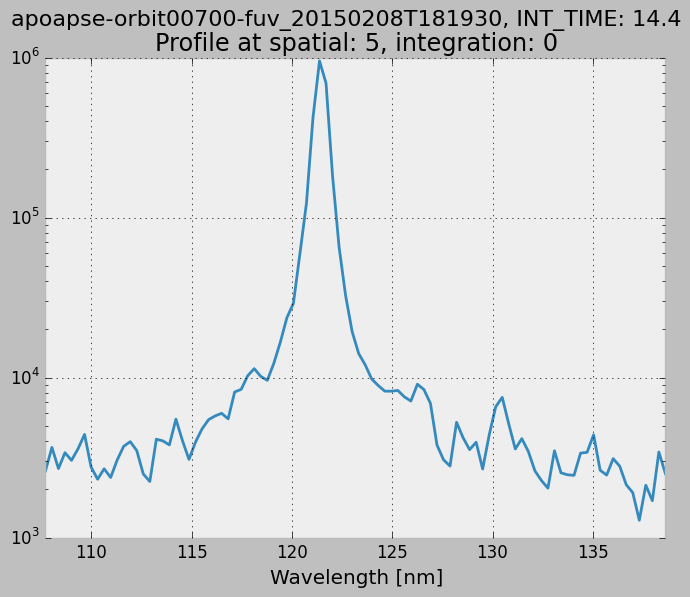

In [106]:
axes = l1b.plot_raw_profile(0, log=True)

In [81]:
axes.get_images()[0]

In [66]:
plt.plot?

In [ ]:
ax.set_x

In [48]:
%debug

> /Users/klay6683/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py(223)_xy_from_xy()
    222         if x.shape[0] != y.shape[0]:
--> 223             raise ValueError("x and y must have same first dimension")
    224         if x.ndim > 2 or y.ndim > 2:

ipdb> up
> /Users/klay6683/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py(282)_plot_args()
    281 
--> 282         x, y = self._xy_from_xy(x, y)
    283 

ipdb> up
> /Users/klay6683/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py(304)_grab_next_args()
    303             if len(remaining) <= 3:
--> 304                 for seg in self._plot_args(remaining, kwargs):
    305                     yield seg

ipdb> up
*** Oldest frame
ipdb> up
*** Oldest frame
ipdb> exit


ValueError: x and y must have same first dimension

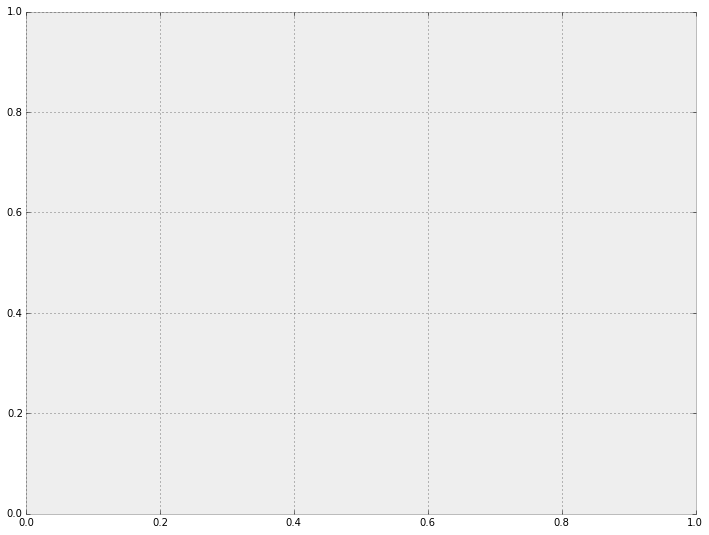

In [44]:
l1b.plot_raw_profile()

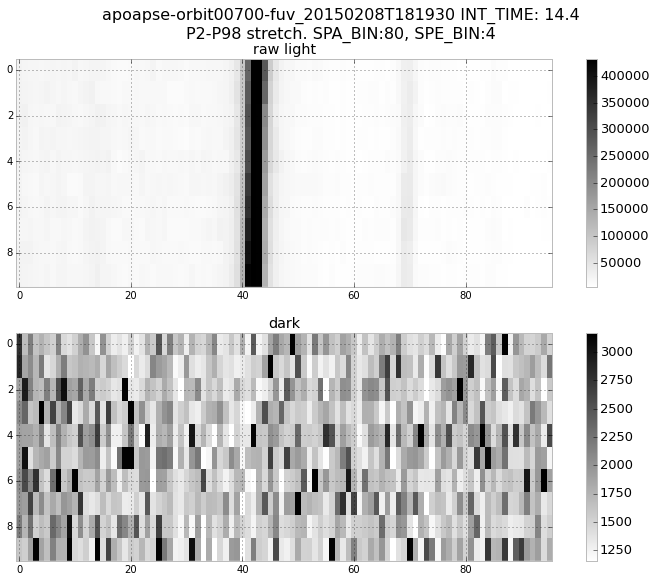

In [72]:
show_image_overview(l1b)

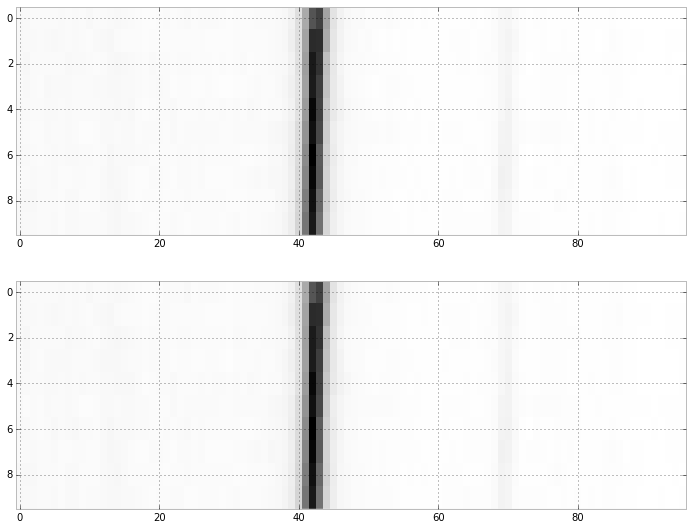

In [23]:
fig, ax = plt.subplots(nrows=2)
cmap = 'binary'
ax[0].imshow(l1b.detector_raw[-1], cmap=cmap)
ax[1].imshow(l1b.detector_background_subtracted[-1], cmap=cmap)

1.0


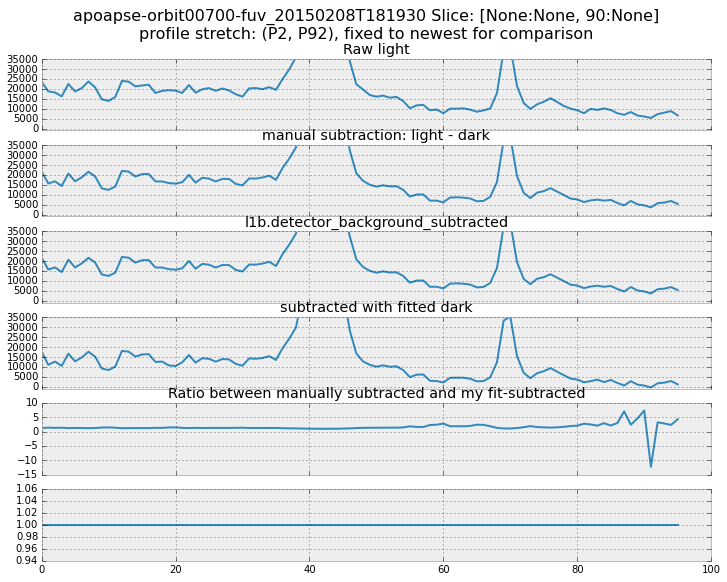

In [33]:
spa_slice = slice(None, None)
spe_slice = slice(90, None)
sub = plot_profiles(l1b, spa_slice, spe_slice)

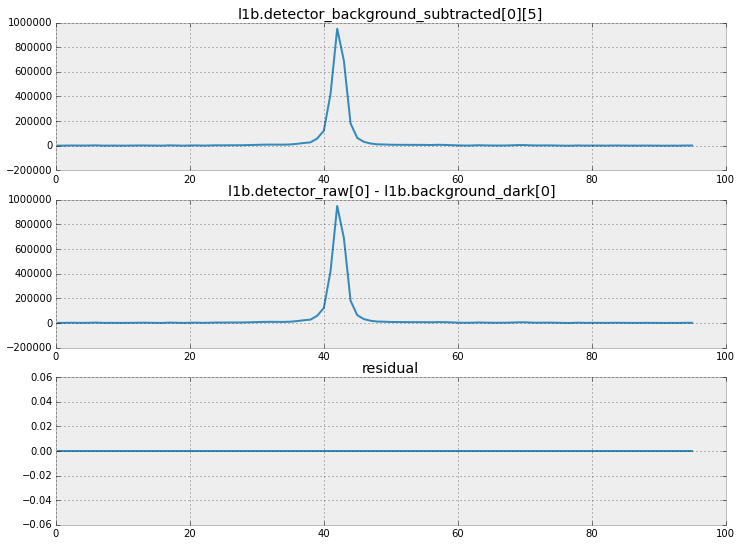

In [21]:
fig, axes = plt.subplots(nrows=3)
axes[0].plot(l1b.detector_background_subtracted[0][5])
axes[0].set_title('l1b.detector_background_subtracted[0][5]')
man_sub = l1b.detector_raw[0] - l1b.background_dark[0]
axes[1].plot(man_sub[5])
axes[1].set_title('l1b.detector_raw[0] - l1b.background_dark[0]')
axes[2].plot(l1b.detector_background_subtracted[0][5] - man_sub[5])
axes[2].set_title('residual')

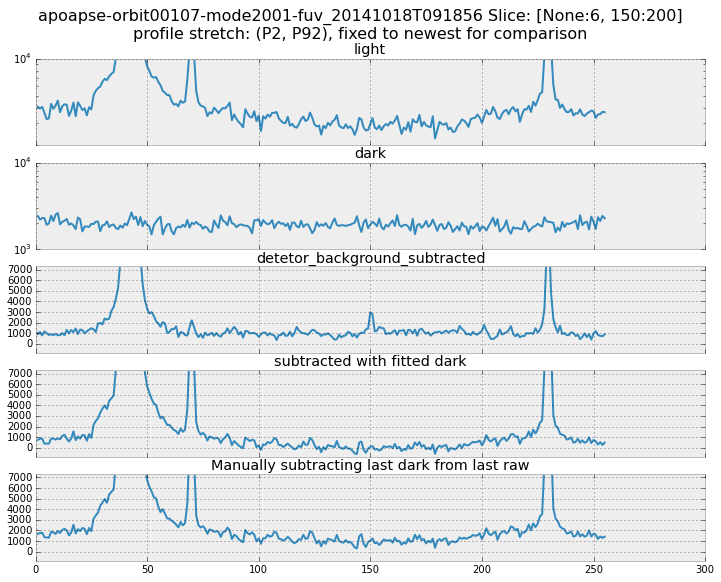

In [56]:
spa_slice = slice(None, 6)
spe_slice = slice(150, 200)
sub = plot_mean_profiles(l1b, spa_slice, spe_slice)

In [35]:
l1b.darks_interpolated.mean(axis=2).mean(axis=1)

array([ 1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867], dtype=float32)

In [47]:
l1b.background_dark.mean(axis=2).mean(axis=1)

array([ 1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867,  1932.22338867,  1932.22338867,  1932.22338867,
        1932.22338867], dtype=float32)

In [37]:
l1b.detector_dark.mean(axis=2).mean(axis=1)

array([ 1997.8109375,  1932.2234375])

(0, 7000)

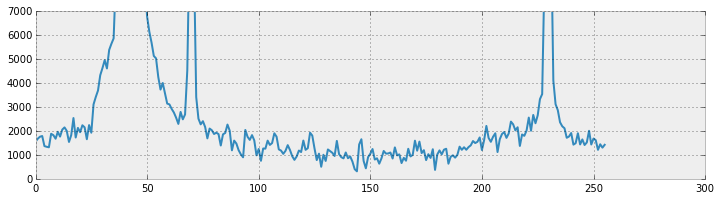

In [52]:
oldsub = l1b.detector_raw[-1] - l1b.detector_dark[-1]
plt.figure(figsize=(12,3))
plt.plot(oldsub.mean(axis=0))
plt.ylim(0, 7000)

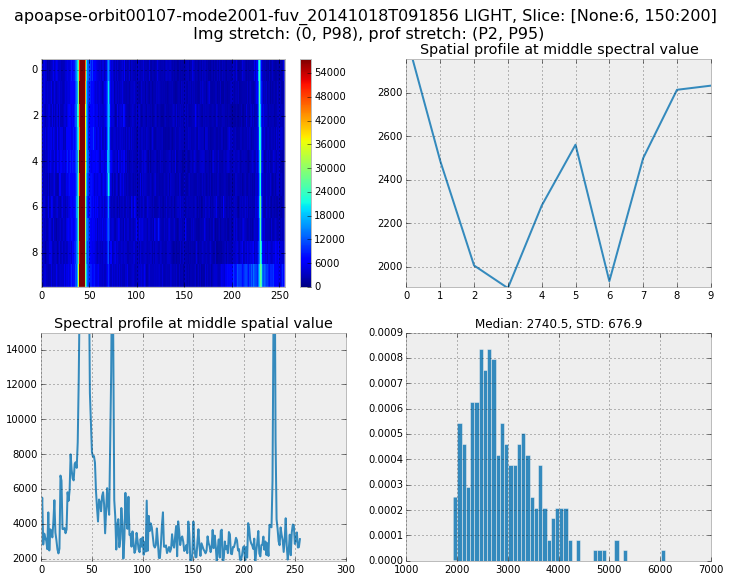

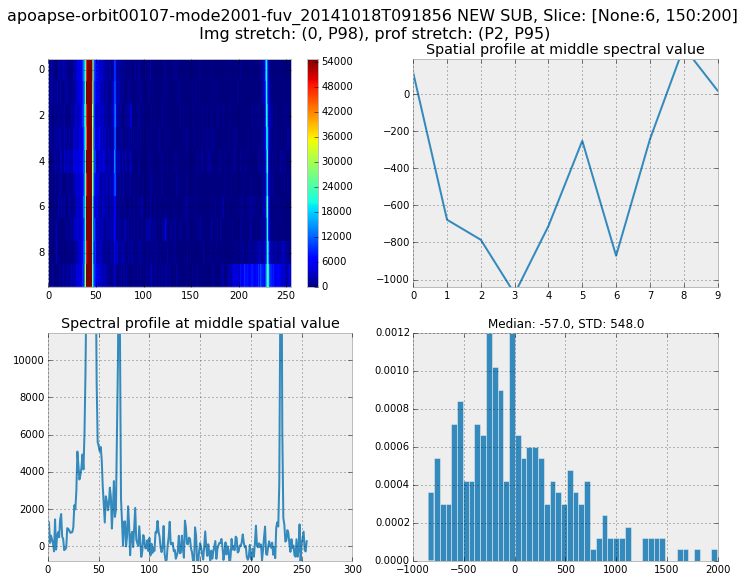

In [50]:
wavelength = l1b.Observation.field(18)[0]

In [58]:
wavelength_width = l1b.Observation.field(19)[0]

In [59]:
wavelength_width.shape

(10, 96)

In [61]:
wavelength_width[0]

array([ 0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32536,
        0.32536,  0.32536,  0.32536,  0.32536,  0.32536,  0.32

In [66]:
l1b.img[5].shape

(10, 96)

In [79]:
panel = pd.Panel(l1b.detector_raw)

In [80]:
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 21 (items) x 10 (major_axis) x 96 (minor_axis)
Items axis: 0 to 20
Major_axis axis: 0 to 9
Minor_axis axis: 0 to 95

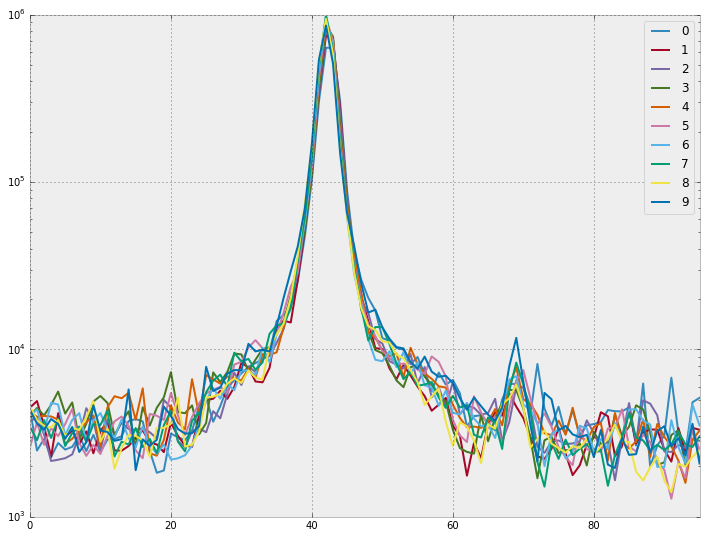

In [82]:
panel[0].T.plot(logy=True)

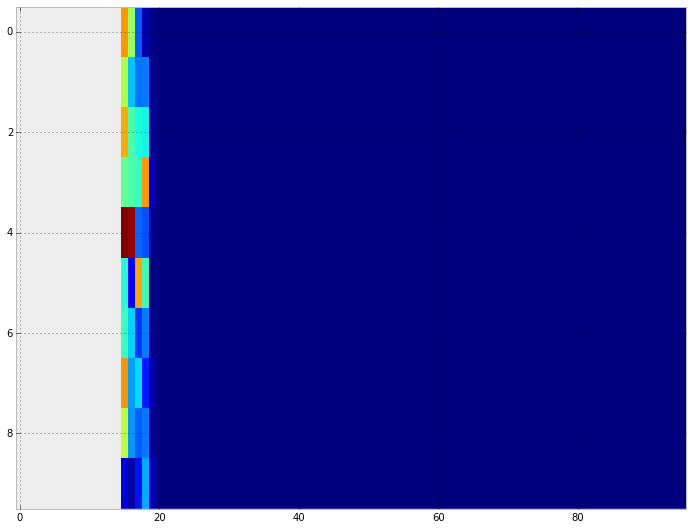

In [83]:
plt.imshow(l1b.img[0])

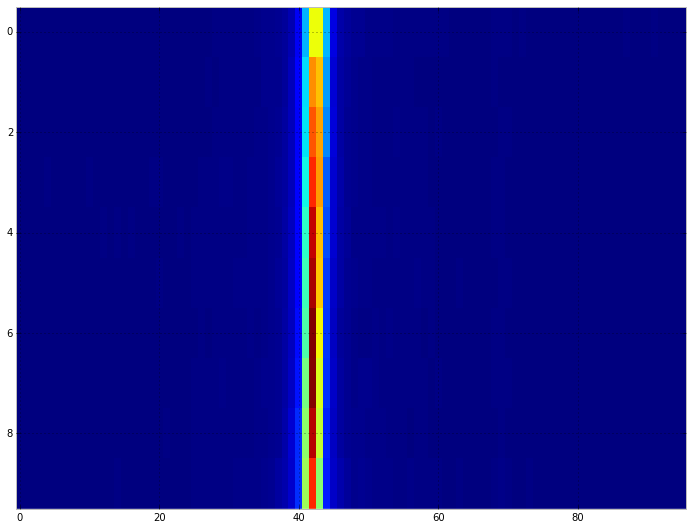

In [84]:
plt.imshow(l1b.detector_raw[0])